ЗАДАНИЯ ДЛЯ ПРОЕКТА

Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.
Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.
С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).
Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
Сделайте выводы по полученным результатам.

In [74]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import pmdarima as pm

In [3]:
data = pd.read_csv(
    "/Users/egor/Documents/data_science_course/SKILLFACTORY/MATH&ML-13. Временные ряды. Часть II/data/ghana_gdp.csv", 
    parse_dates=["year"], 
    index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


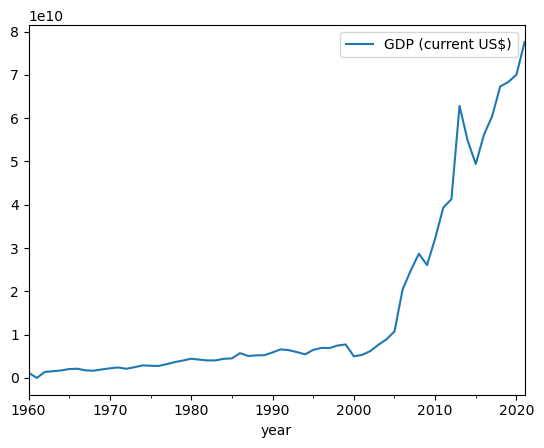

In [5]:
data.plot()
plt.show()

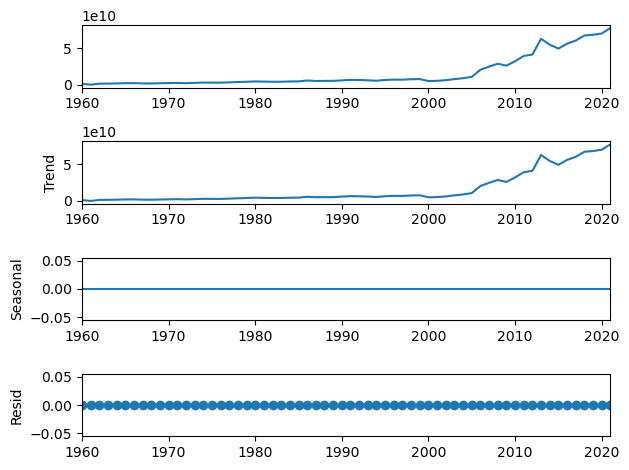

In [7]:
decomposition = seasonal_decompose(data)
decomposition.plot()
plt.show()

In [19]:
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]
test_df

,GDP (current US$)
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [23]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  0.6529066974885374
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


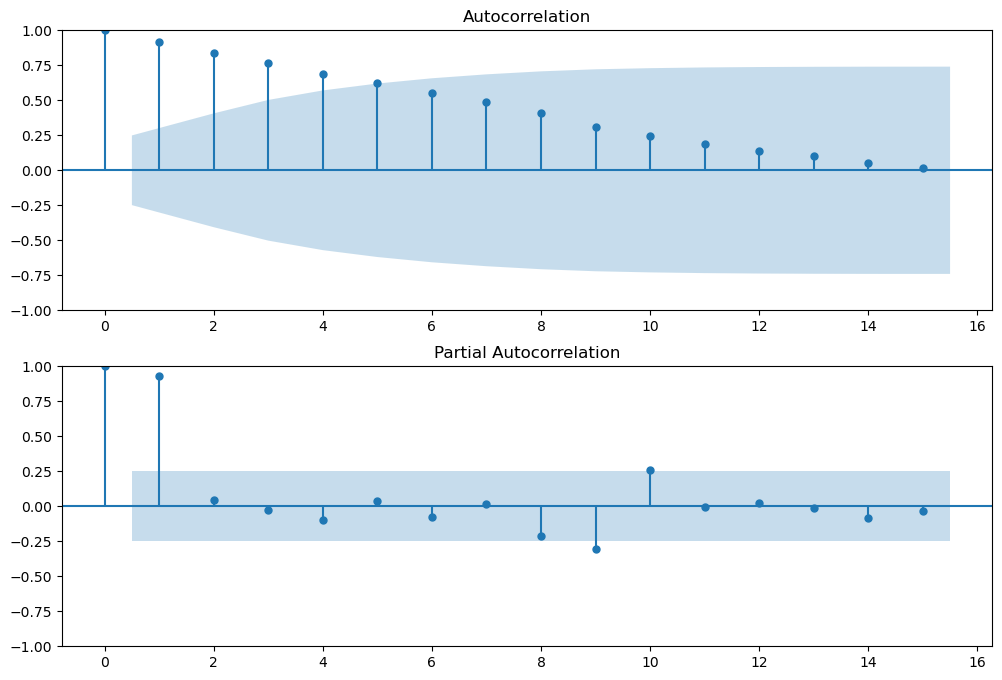

In [30]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=15, ax=ax2)

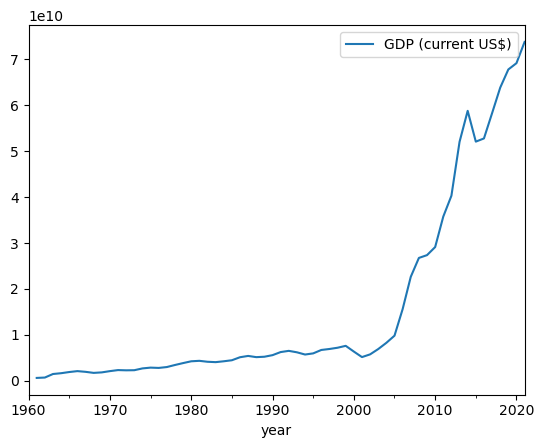

In [38]:
data_ma = data.rolling(window=2).mean()
data_ma.plot()
plt.show()

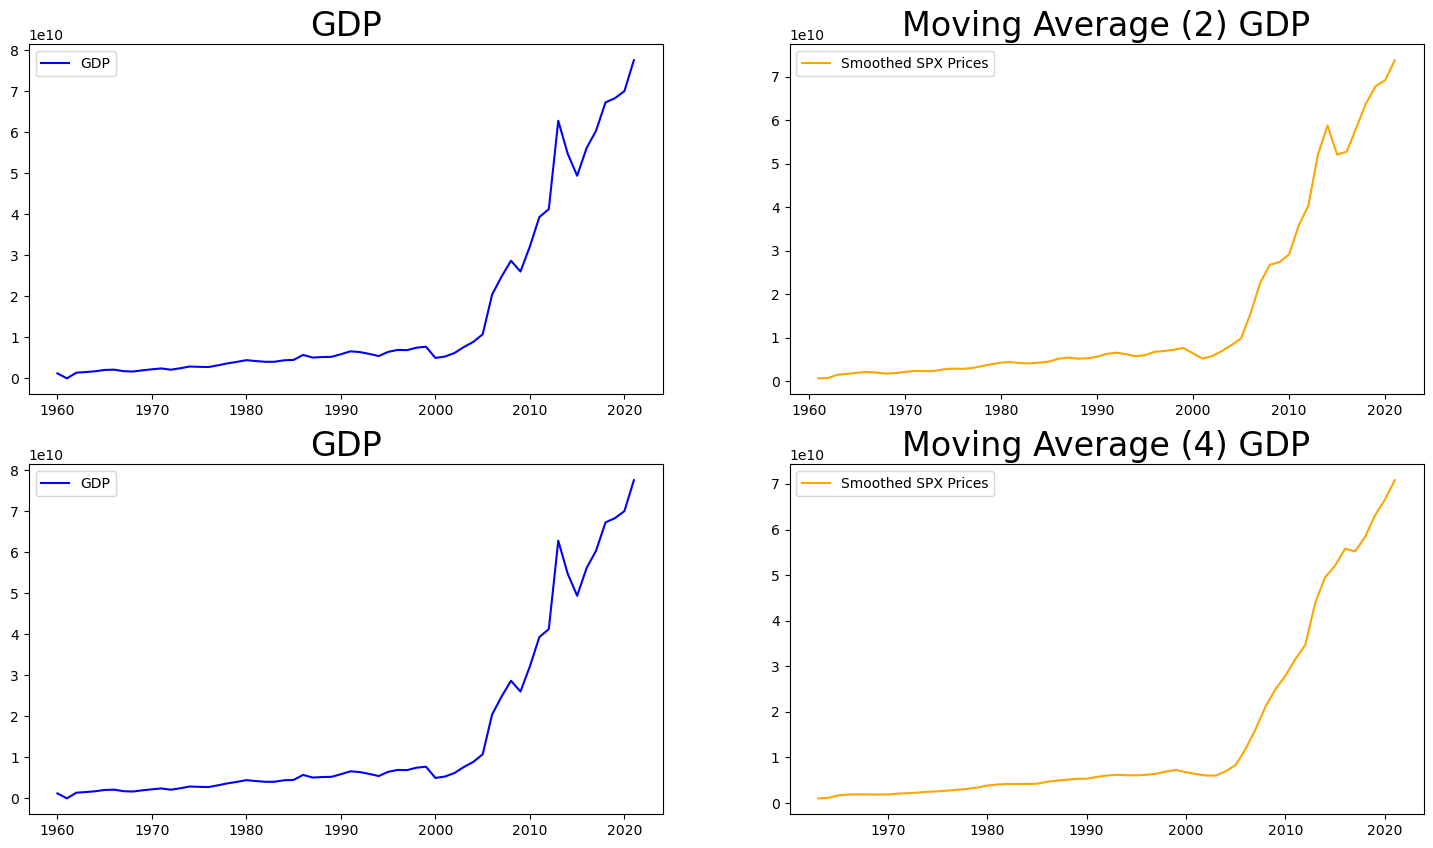

In [39]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(data, color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    data.rolling(window=2).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[0, 1].set_title("Moving Average (2) GDP", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(data, color="blue", label="GDP")
ax[1, 0].set_title("GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    data.rolling(window=4).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[1, 1].set_title("Moving Average (4) GDP", size=24)
ax[1, 1].legend()

plt.show()

In [40]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(data)

adf:  2.3738393561489173
p-value:  0.9989974617734
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
есть единичные корни, ряд не стационарен


In [48]:
data_1diff = data.diff().dropna()
data_2diff = data_1diff.diff().dropna()
data_3diff = data_2diff.diff().dropna()
stat_test(data_3diff)

adf:  -5.278476343687454
p-value:  6.066691711555469e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


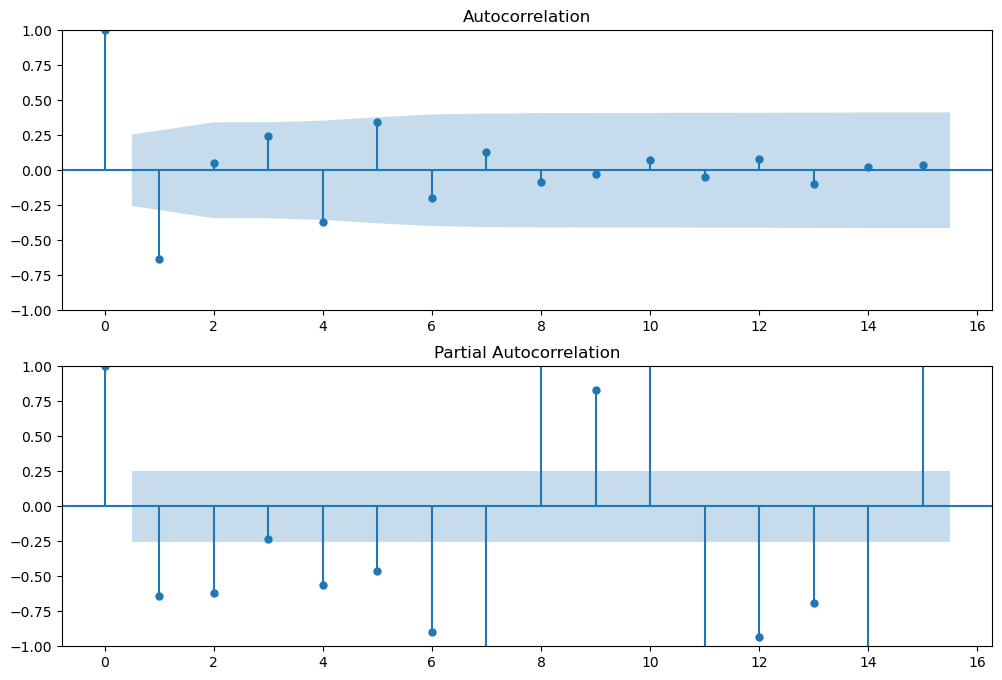

In [54]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_3diff.values.squeeze(), lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_3diff, lags=15, ax=ax2)

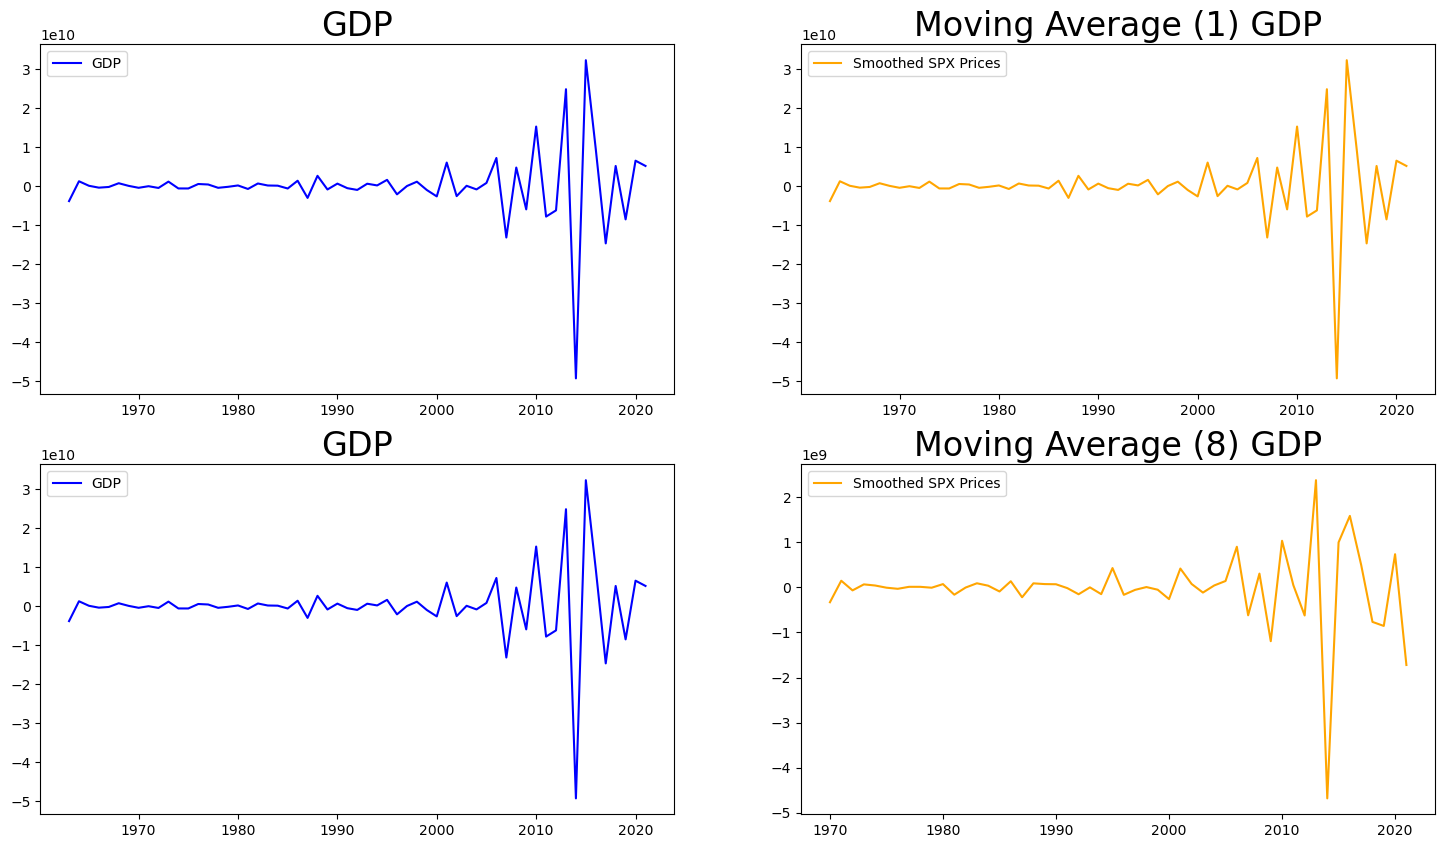

In [58]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(data_3diff, color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    data_3diff.rolling(window=1).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[0, 1].set_title("Moving Average (1) GDP", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(data_3diff, color="blue", label="GDP")
ax[1, 0].set_title("GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    data_3diff.rolling(window=8).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[1, 1].set_title("Moving Average (8) GDP", size=24)
ax[1, 1].legend()

plt.show()

In [59]:
arima_model = ARIMA(train_df, order=(1, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/egor/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 1)   Log Likelihood               -1332.455
Date:                Wed, 19 Jul 2023   AIC                           2670.910
Time:                        13:46:39   BIC                           2676.986
Sample:                    01-01-1960   HQIC                          2673.266
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.091     -5.600      0.000      -0.685      -0.330
ma.L1         -0.9751      0.132     -7.380      0.000      -1.234      -0.716
sigma2      4.066e+19   1.88e-21   2.17e+40      0.000    4.07e+19    4.07e+19
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               140.21
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             441.28   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.71e+55. Standard errors may be unstable.
"""

In [71]:
pred_df = pd.DataFrame(index=test_df.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = test_df['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

In [72]:
pred_df

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,7.305428e+10,6.833754e+10,6.054082e+10,8.556773e+10
2020-01-01,7.959387e+10,7.004320e+10,5.682570e+10,1.023620e+11
2021-01-01,8.594276e+10,7.759428e+10,4.913797e+10,1.227476e+11


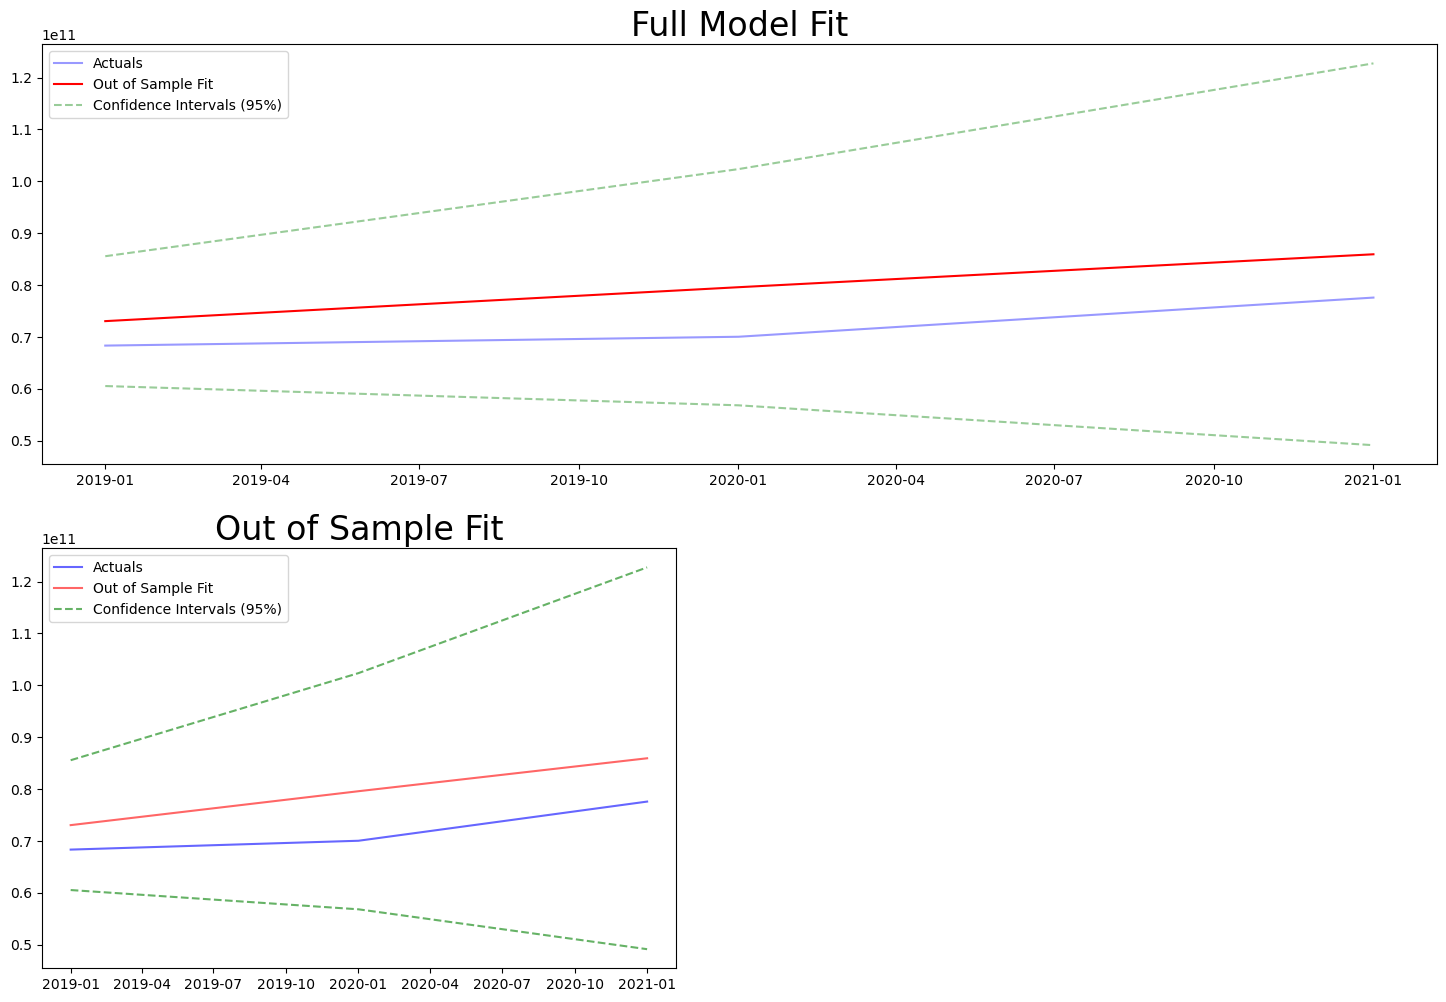

In [73]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [78]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=15,
    D=3,
    start_P=0,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.01 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.01 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.222 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 19 Jul 2023   AIC                           2659.231
Time:                        14:12:06   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+56. Standard errors may be unstable.
"""

In [79]:
arima_model = ARIMA(train_df, order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

/Users/egor/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/egor/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 19 Jul 2023   AIC                           2659.231
Time:                        14:12:33   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+56. Standard errors may be unstable.
"""

In [82]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

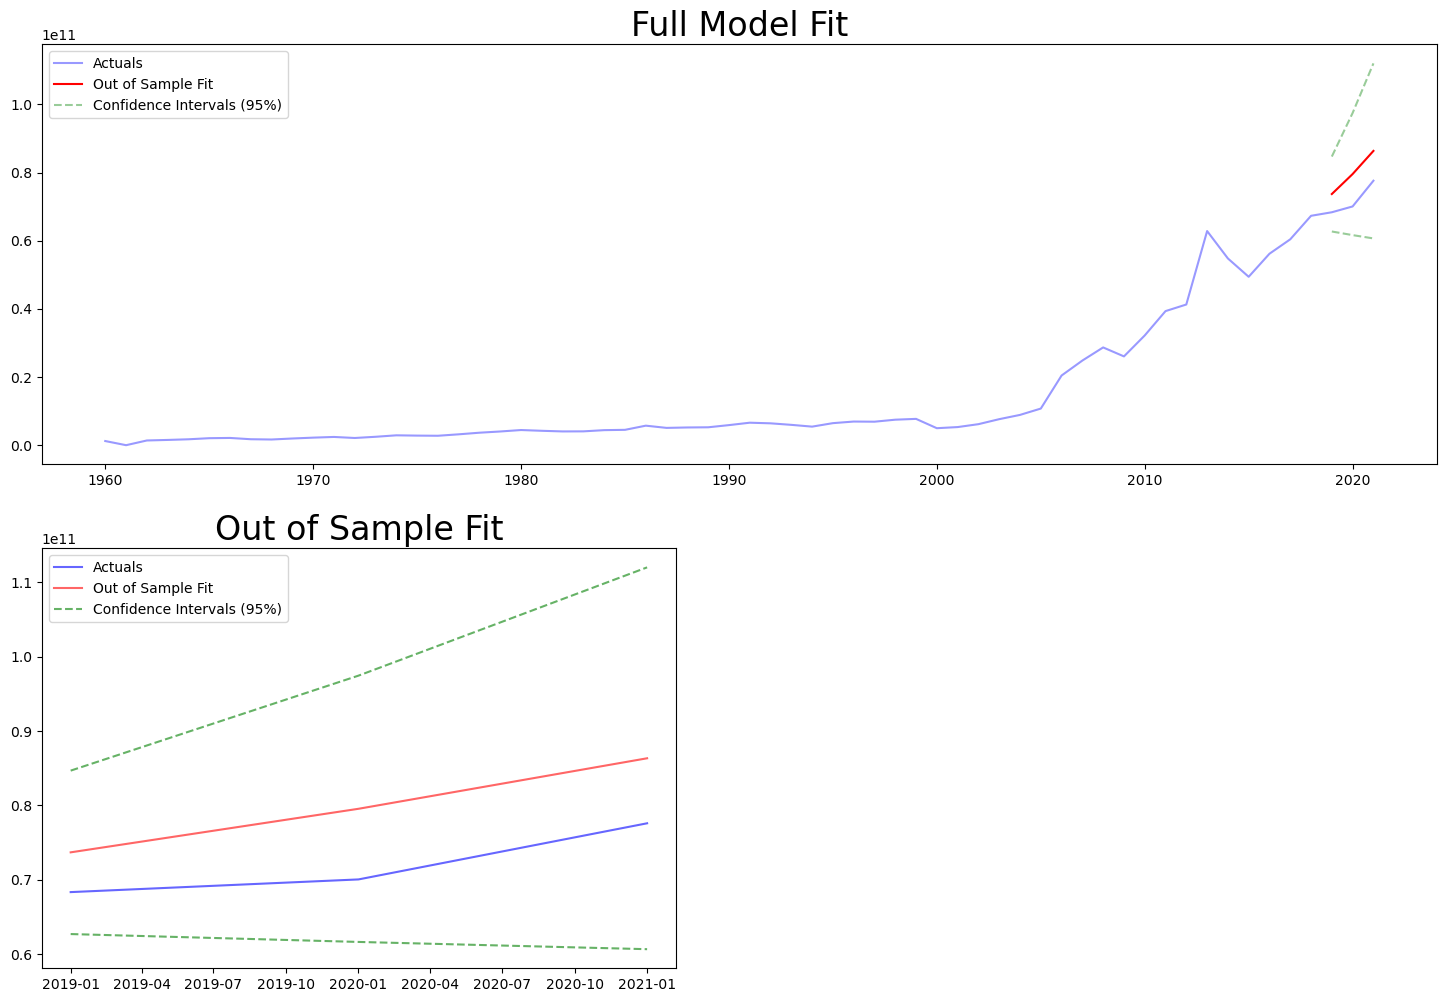

In [83]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()